In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ssl_df = pd.read_csv('data/Strategic_Subject_List.csv', dtype={'CENSUS_TRACT': 'object'})
# Applying census tract cleanup from other notebook
short_census = ssl_df.loc[ssl_df['CENSUS_TRACT'].str.len() < 10].copy()
short_census_tracts = short_census['CENSUS_TRACT'].unique().tolist()[1:]
long_tracts = list(filter(lambda x: isinstance(x, str), ssl_df['CENSUS_TRACT'].unique().tolist()))
long_tracts = list(filter(lambda x: len(x) > 8, long_tracts))

col_map = {}
for c in short_census_tracts:
    for t in long_tracts:
        if t.endswith(c):
            col_map[c] = t
            
def convert_short_tracts(val):
    if col_map.get(val):
        return col_map[val]
    else:
        return val
    
ssl_df['CENSUS_TRACT'] = ssl_df['CENSUS_TRACT'].apply(convert_short_tracts)
ssl_df.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SSL_SCORE,PREDICTOR_RAT_AGE_AT_LATEST_ARREST,PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS,PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT,PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES,PREDICTOR_RAT_GANG_AFFILIATION,PREDICTOR_RAT_NARCOTIC_ARRESTS,PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY,PREDICTOR_RAT_UUW_ARRESTS,SEX_CODE_CD,...,RAW_HEAT_SCORE,STATUS_I,PRE_RAW_HEAT_SCORE,TRAP_FLAGS,SSL_FLAGS,LATITUDE,LONGITUDE,CENSUS_TRACT,COMMUNITY_AREA,LOCATION
0,500,20-30,0,1,4,1,1,1.0,1,M,...,0.14196,Y,14196,NaN,24.0,NaN,NaN,NaN,,NaN
1,500,20-30,0,9,1,1,0,1.0,0,M,...,0.14511,Y,14511,NaN,8.0,NaN,NaN,NaN,,NaN
2,500,less than 20,1,2,1,1,3,1.0,0,M,...,0.12982,Y,12982,NaN,8.0,NaN,NaN,NaN,,NaN
3,500,less than 20,1,1,4,1,0,1.6,1,M,...,0.13110,Y,13110,NaN,NaN,NaN,NaN,NaN,,NaN
4,500,less than 20,0,0,5,0,0,1.3,3,M,...,0.12874,Y,12874,NaN,NaN,NaN,NaN,NaN,,NaN


In [3]:
tract_df = gpd.read_file('data/chi_census_tracts.geojson')
tract_df.head()

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10
0,44,44,031,17031842400,(POLYGON ((-87.62404799998049 41.7302169999839...,8424,Census Tract 8424,,17,842400
1,59,59,031,17031840300,(POLYGON ((-87.6860799999848 41.82295600001154...,8403,Census Tract 8403,,17,840300
2,34,34,031,17031841100,(POLYGON ((-87.62934700001182 41.8527970000265...,8411,Census Tract 8411,,17,841100
3,31,31,031,17031841200,(POLYGON ((-87.68813499997718 41.8556909999909...,8412,Census Tract 8412,,17,841200
4,28,28,031,17031838200,(POLYGON ((-87.66781999997529 41.8741839999791...,8382,Census Tract 8382,,17,838200


In [4]:
ssl_tract_group = ssl_df.groupby('CENSUS_TRACT')['SSL_SCORE'].count()
tract_group_df = pd.DataFrame(ssl_tract_group).reset_index()

tract_merge_df = tract_df.merge(tract_group_df, left_on='geoid10', right_on='CENSUS_TRACT', how='left')
crs = {'init': 'epsg:4326'}
tract_merge_df.crs = crs
tract_merge_df.rename(columns={'SSL_SCORE': 'ssl_count'}, inplace=True)
tract_merge_df.head()

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10,CENSUS_TRACT,ssl_count
0,44,44,031,17031842400,(POLYGON ((-87.62404799998049 41.7302169999839...,8424,Census Tract 8424,,17,842400,17031842400,1641.0
1,59,59,031,17031840300,(POLYGON ((-87.6860799999848 41.82295600001154...,8403,Census Tract 8403,,17,840300,17031840300,248.0
2,34,34,031,17031841100,(POLYGON ((-87.62934700001182 41.8527970000265...,8411,Census Tract 8411,,17,841100,17031841100,371.0
3,31,31,031,17031841200,(POLYGON ((-87.68813499997718 41.8556909999909...,8412,Census Tract 8412,,17,841200,17031841200,305.0
4,28,28,031,17031838200,(POLYGON ((-87.66781999997529 41.8741839999791...,8382,Census Tract 8382,,17,838200,17031838200,451.0


In [5]:
from shapely.geometry import Point

isr_df = pd.read_csv('data/contact_cards_geocoded.csv')
isr_df = isr_df.dropna(subset=['lat', 'lon'])
geometry = [Point(xy) for xy in zip(isr_df.lon, isr_df.lat)]
isr_df = isr_df.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
isr_geo_df = gpd.GeoDataFrame(isr_df, crs=crs, geometry=geometry)
isr_geo_df.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (0,4,11,13,14,16,18,19,22,23,29,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,59,63,64,65,66,72,74,75,100,102,103,104,110,111,117,119,120,121,132,134,138,139,140,141,142,143,144,146,148,150,152,153,154,155,156,157,159,161,163,164,166,169) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,...,S_STOLEN_PROPERTY_I,S_STOLEN_PROPERTY_INVENTORY_NO,GANG_OTHER,OTHER_DESCR,OTHER_INVENTORY_NO,S_OTHER_I,S_OTHER_DESCR,S_OTHER_INVENTORY_NO,NAME,geometry
0,20011720,INVSTG,ISR000011720,1/1/2016 0:02,0,1561,N,BLUE JEANS/ DARK JACKET,NaN,HZ100007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLACK P STONES,POINT (-87.76201533715374 41.89192170398553)
1,20011719,INVSTG,ISR000011719,1/1/2016 0:02,0,1561,N,UNK,NaN,HZ100007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLACK P STONES,POINT (-87.76201533715374 41.89192170398553)
2,20011724,INVSTG,ISR000011724,1/1/2016 0:04,0,1561,N,GRAY JEANS AND BLACK PELLE PELLE JACKET,Y,HZ100007,...,NaN,NaN,NaN,NaN,NaN,Y,3 LIVE 380 ROUNDS,13600443,BLACK P STONES,POINT (-87.76201533715374 41.89192170398553)
3,20011728,INVSTG,ISR000011728,1/1/2016 0:25,0,1884,N,"BLACK/WHITE CHECKERED SHIRT, BLUE JEANS",Y,HZ100013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.62867799999998 41.903942)
4,20011772,INVSTG,ISR000011772,1/1/2016 0:54,0,1611,N,BLACK JACET AND BLACL PANTS,Y,HZ100058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.77618808260559 41.93765883903622)


In [6]:
from geopandas.tools import sjoin

isr_sjoin_tract = sjoin(isr_geo_df, tract_df, how='left')
isr_sjoin_tract.head()

,CONTACT_CARD_ID,CONTACT_TYPE_CD,CARD_NO,CONTACT_DATE,CONTACT_HOUR,SUBMITTING_BEAT_CD,JUVENILE_I,CLOTHING_DESCR,NAME_VERIFIED_I,RD_NO,...,index_right,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10
0,20011720,INVSTG,ISR000011720,1/1/2016 0:02,0,1561,N,BLUE JEANS/ DARK JACKET,NaN,HZ100007,...,672,25,25,031,17031251500,2515,Census Tract 2515,,17,251500
1,20011719,INVSTG,ISR000011719,1/1/2016 0:02,0,1561,N,UNK,NaN,HZ100007,...,672,25,25,031,17031251500,2515,Census Tract 2515,,17,251500
2,20011724,INVSTG,ISR000011724,1/1/2016 0:04,0,1561,N,GRAY JEANS AND BLACK PELLE PELLE JACKET,Y,HZ100007,...,672,25,25,031,17031251500,2515,Census Tract 2515,,17,251500
3,20011728,INVSTG,ISR000011728,1/1/2016 0:25,0,1884,N,"BLACK/WHITE CHECKERED SHIRT, BLUE JEANS",Y,HZ100013,...,229,8,8,031,17031081100,811,Census Tract 811,,17,081100
4,20011772,INVSTG,ISR000011772,1/1/2016 0:54,0,1611,N,BLACK JACET AND BLACL PANTS,Y,HZ100058,...,81,19,19,031,17031190402,1904.02,Census Tract 1904.02,,17,190402


In [7]:
isr_by_tract = isr_sjoin_tract.groupby('geoid10')['CONTACT_CARD_ID'].count()
isr_by_tract_df = pd.DataFrame(isr_by_tract).reset_index()
isr_by_tract_df.rename(columns={'CONTACT_CARD_ID': 'isr_count'}, inplace=True)
isr_by_tract_df.head()

,geoid10,isr_count
0,17031010100,314
1,17031010201,165
2,17031010202,111
3,17031010300,135
4,17031010400,77


In [8]:
tract_merge_isr = tract_df.merge(isr_by_tract_df, on='geoid10', how='left')
tract_merge_isr.head()

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10,isr_count
0,44,44,031,17031842400,(POLYGON ((-87.62404799998049 41.7302169999839...,8424,Census Tract 8424,,17,842400,576.0
1,59,59,031,17031840300,(POLYGON ((-87.6860799999848 41.82295600001154...,8403,Census Tract 8403,,17,840300,79.0
2,34,34,031,17031841100,(POLYGON ((-87.62934700001182 41.8527970000265...,8411,Census Tract 8411,,17,841100,434.0
3,31,31,031,17031841200,(POLYGON ((-87.68813499997718 41.8556909999909...,8412,Census Tract 8412,,17,841200,318.0
4,28,28,031,17031838200,(POLYGON ((-87.66781999997529 41.8741839999791...,8382,Census Tract 8382,,17,838200,370.0


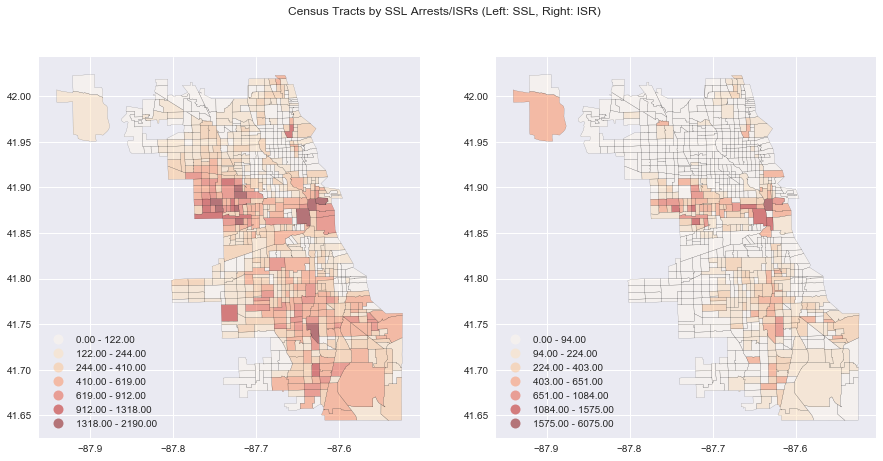

In [9]:
plt.rcParams["figure.figsize"] = [15, 7]
fig, axs = plt.subplots(1,2)

tract_merge_df['ssl_count'].fillna(0, inplace=True)
tract_merge_isr['isr_count'].fillna(0, inplace=True)

plt.suptitle('Census Tracts by SSL Arrests/ISRs (Left: SSL, Right: ISR)')

tract_merge_df.plot(column='ssl_count', scheme='fisher_jenks', k=7, 
                    cmap='OrRd', ax=axs[0], linewidth=0.1, legend=True)
tract_merge_isr.plot(column='isr_count', scheme='fisher_jenks', k=7, 
                     cmap='OrRd', ax=axs[1], linewidth=0.1, legend=True)